### Dataset_Prep

In [13]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
import keras
from keras.metrics import MeanIoU
import random
import glob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# from keras.applications.resnet50 import preprocess_input, decode_predictions
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess_input = keras.applications.resnet_v2.preprocess_input()

In [14]:
train_imgs = np.load('data/train_img_256.npy')
train_msks = np.load('data/train_msk_256.npy')
val_imgs = np.load('data/val_img_256.npy')
val_msks = np.load('data/val_msk_256.npy')

print(train_imgs.shape)
train_imgs=np.append(train_imgs,val_imgs[500:-1,:,:,:]).reshape(-1,128, 128, 7)
train_msks=np.append(train_msks,val_msks[500:-1,:,:,:]).reshape(-1,128, 128, 3)

val_imgs=val_imgs[0:500,:,:,:]
val_msks=val_msks[0:500,:,:,:]
print(train_imgs.shape)
print(len(train_imgs),len(val_imgs))

(698, 256, 256, 7)


ValueError: cannot reshape array of size 182976512 into shape (128,128,3)

In [ ]:
train_msks.shape

In [3]:
class Augment(keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = keras.Sequential([
                  keras.layers.RandomFlip("horizontal_and_vertical",seed=42),
                  keras.layers.RandomRotation(factor=(-0.2, 0.3) ,seed=42),
                  # keras.layers.RandomZoom(height_factor=(0.2, 0.3), seed=42),  # Zoom in/out 20%
                  # keras.layers.RandomBrightness(0.2,value_range=(0, 1), seed=42),  # Adjust contrast by 10%
                  keras.layers.RandomContrast(0.2, seed=42),
                  # keras.layers.RandomTranslation(0.05,0.05,seed=42)
                ])

        
        # Use the same seed to keep inputs and labels transformations consistent
        self.augment_labels = keras.Sequential([
                  keras.layers.RandomFlip("horizontal_and_vertical",seed=42),
                  keras.layers.RandomRotation(factor=(-0.2, 0.3),seed=42),
                  # keras.layers.RandomZoom(height_factor=(0.2, 0.3), seed=42),  # Zoom in/out 20%
                  # keras.layers.RandomTranslation(0.05,0.05,seed=42)
                ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels_1 = self.augment_labels(labels)
        return inputs,labels_1

In [4]:
def preprocess_data(img, mask, channel = 3, join=False):
    img = preprocess_input(img)
    print(img.shape)
    print(mask.shape)
    if(join == True):
        mask1= mask[:,:,0] + mask[:,:,1]
        mask_2 = tf.one_hot(tf.cast(mask1, tf.int32), depth=2)
        mask = (mask,mask_2)
    return img, mask

def prep(data, ch, target_size=(64, 64)):
    img_dataset = tf.data.Dataset.from_tensor_slices(data)
    
    def resize_image(image):
        image = tf.image.resize(image, target_size)
        image = tf.ensure_shape(image, (target_size[0], target_size[1], ch))
        return image

    img_dataset = img_dataset.map(resize_image)
    
    for img in img_dataset.take(1):
        print(img.shape)
    
    return img_dataset
    

def trainGenerator(img_array, mask_array, batch_size, seed=None, eval_set=False,bands=6,target_size=(128, 128)):
    img_dataset = prep(img_array[:,:,:,:bands],bands,target_size)
    mask_dataset = prep(mask_array,3,target_size)

    dataset = tf.data.Dataset.zip((img_dataset, mask_dataset))

    dataset_1 = dataset.map(lambda img, mask: preprocess_data(img, mask, 3, False), num_parallel_calls=tf.data.AUTOTUNE)

    # Continue with batching, repeating, etc.
    if eval_set!=True:
        dataset_1 = dataset_1.batch(batch_size).repeat().map(Augment()).prefetch(tf.data.AUTOTUNE)
    else:
        dataset_1 = dataset_1.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset_1

train_img_gen = trainGenerator(train_imgs,train_msks,batch_size=128,bands=6)
valid_img_gen = trainGenerator(val_imgs,val_msks,batch_size=128,eval_set=True,bands=6)

2024-03-22 13:39:11.827034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38080 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


(128, 128, 6)
(128, 128, 3)
(128, 128, 6)
(128, 128, 3)
(128, 128, 6)
(128, 128, 3)
(128, 128, 6)
(128, 128, 3)


In [5]:
train_img_gen

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

In [6]:
valid_img_gen

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

###### ResNet50V2

In [7]:
batch_size = 16

steps_per_epoch = len(train_imgs)//batch_size
val_steps_per_epoch = len(val_imgs)//batch_size
mIou = keras.metrics.OneHotMeanIoU(num_classes=3)
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 4
n_classes = 3

In [8]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice coefficient between tensors of true and predicted labels.
    
    :param y_true: tensor of true labels, one-hot encoded.
    :param y_pred: tensor of predicted labels.
    :param smooth: small constant to avoid division by zero.
    :return: Dice coefficient.
    """
    # Compute the intersection
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    # Compute the union
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    # Compute the Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    # Return the mean over the batch
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss, which is 1 minus the Dice coefficient.
    
    :param y_true: tensor of true labels, one-hot encoded.
    :param y_pred: tensor of predicted labels.
    :return: Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)
import tensorflow as tf

def mIoU(y_true, y_pred):
    """
    Calculate mean Intersection-Over-Union (mIOU) for one-hot encoded segmentation masks.
    
    :param y_true: The ground truth segmentation mask, one-hot encoded.
    :param y_pred: The predicted segmentation mask, before softmax or after argmax to one-hot encode.
    :param num_classes: The number of classes.
    :return: The mean IOU score.
    """
    # # If y_pred is not one-hot encoded (e.g., from a softmax layer), convert it using argmax
    # y_pred = tf.argmax(y_pred, axis=-1)
    # y_pred = tf.one_hot(y_pred, depth=num_classes)
    
    # Ensure the predictions are of type float32
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate IOU for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection
    
    # Smooth to avoid division by zero
    iou = (intersection + 1e-7) / (union + 1e-7)
    
    # Calculate mean IOU across all classes
    mean_iou = tf.reduce_mean(iou, axis=-1)
    
    return mean_iou


def data_prep(y_true, y_pred,num_classes=2):
    # Calculate per-class TP, FP, and FN
    tp = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=[0, 1, 2])
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=[0, 1, 2])

  
    return tp, fp, fn
    
def pre_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    precision = tp / (tp + fp + 1e-5)
    return precision
    
def rec_cal(y_true, y_pred,num_classes=2):
    tp, fp, fn = data_prep(y_true, y_pred,num_classes)
    recall = tp / (tp + fn + 1e-5)
    return recall
    
def f1_score(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    recall = rec_cal(y_true, y_pred,num_classes)
    f1_scores = 2 * ((precision * recall) / (precision + recall + 1e-5)) 
    return f1_scores
    
def precision_0(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[0]
    
def precision_1(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[1]
    
def precision_2(y_true, y_pred,num_classes=2):
    precision =  pre_cal(y_true, y_pred,num_classes)
    return precision[2]
    
def recall_0(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[0]
    
def recall_1(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[1]
    
def recall_2(y_true, y_pred,num_classes=2):
    recall = rec_cal(y_true, y_pred,num_classes)
    return recall[2]

    
def f1_score0(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[0]

    
def f1_score1(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[1]

    
def f1_score2(y_true, y_pred,num_classes=2):
    f1_scores=f1_score(y_true, y_pred,num_classes)
    return f1_scores[2]

In [9]:
from keras.layers import Input, Conv2D
from keras.models import Model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                classes=n_classes, activation='softmax')

inp = Input(shape=(None, None, 6))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = model(l1)

model = Model(inp, out, name=model.name)

In [10]:
model.load_weights('/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/model_ckpt/6_res50_16.keras')

In [11]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00000001)
checkpoint_filepath = 'model_ckpt/6_res50_16_128.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.00004), loss=dice_loss, 
                                              metrics=['accuracy','precision','recall',mIoU,
                                              f1_score,f1_score0,f1_score1,f1_score2,
                                              precision_0,precision_1,precision_2,recall_0,recall_1,recall_2])

In [21]:
# model.load_weights('model_ckpt/mres50_1.weights.h5')

In [13]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=2,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/30


2024-03-21 21:10:28.232984: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564d0bdda960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 21:10:28.233037: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-21 21:10:29.158292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-21 21:10:31.704969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-03-21 21:11:00.082498: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_422', 48 bytes spill stores, 48 bytes spill loads

2024-03-21 21:11:07.515867: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at 

174/174 - 184s - 1s/step - accuracy: 0.7664 - f1_score: 0.7531 - f1_score0: 0.7171 - f1_score1: 0.7247 - f1_score2: 0.8174 - loss: 0.2354 - m_io_u: 0.4435 - precision: 0.7959 - precision_0: 0.7321 - precision_1: 0.7198 - precision_2: 0.8099 - recall: 0.7418 - recall_0: 0.7066 - recall_1: 0.7356 - recall_2: 0.8258 - val_accuracy: 0.7229 - val_f1_score: 0.6931 - val_f1_score0: 0.6832 - val_f1_score1: 0.5865 - val_f1_score2: 0.8096 - val_loss: 0.2773 - val_m_io_u: 0.4206 - val_precision: 0.7231 - val_precision_0: 0.6410 - val_precision_1: 0.7282 - val_precision_2: 0.7874 - val_recall: 0.7228 - val_recall_0: 0.7322 - val_recall_1: 0.4926 - val_recall_2: 0.8335 - learning_rate: 4.0000e-05
Epoch 2/30
174/174 - 77s - 440ms/step - accuracy: 0.7876 - f1_score: 0.7750 - f1_score0: 0.7455 - f1_score1: 0.7519 - f1_score2: 0.8276 - loss: 0.2142 - m_io_u: 0.4580 - precision: 0.8174 - precision_0: 0.7602 - precision_1: 0.7498 - precision_2: 0.8196 - recall: 0.7618 - recall_0: 0.7333 - recall_1: 0.755

2024-03-21 21:18:23.036645: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:18:23.036709: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574
2024-03-21 21:19:43.019451: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:19:43.019511: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 81s - 466ms/step - accuracy: 0.8156 - f1_score: 0.8051 - f1_score0: 0.7810 - f1_score1: 0.7894 - f1_score2: 0.8450 - loss: 0.1860 - m_io_u: 0.4870 - precision: 0.8456 - precision_0: 0.7957 - precision_1: 0.7860 - precision_2: 0.8401 - recall: 0.7882 - recall_0: 0.7683 - recall_1: 0.7941 - recall_2: 0.8504 - val_accuracy: 0.7324 - val_f1_score: 0.7126 - val_f1_score0: 0.6719 - val_f1_score1: 0.6555 - val_f1_score2: 0.8105 - val_loss: 0.2678 - val_m_io_u: 0.4340 - val_precision: 0.7326 - val_precision_0: 0.7152 - val_precision_1: 0.6574 - val_precision_2: 0.7750 - val_recall: 0.7322 - val_recall_0: 0.6337 - val_recall_1: 0.6539 - val_recall_2: 0.8503 - learning_rate: 4.0000e-05
Epoch 7/30
174/174 - 80s - 457ms/step - accuracy: 0.8201 - f1_score: 0.8103 - f1_score0: 0.7863 - f1_score1: 0.7964 - f1_score2: 0.8482 - loss: 0.1814 - m_io_u: 0.4931 - precision: 0.8502 - precision_0: 0.8017 - precision_1: 0.7907 - precision_2: 0.8434 - recall: 0.7925 - recall_0: 0.7727 - recall_1: 0.8

2024-03-21 21:25:01.643581: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:25:01.643632: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 80s - 463ms/step - accuracy: 0.8321 - f1_score: 0.8229 - f1_score0: 0.8013 - f1_score1: 0.8098 - f1_score2: 0.8575 - loss: 0.1695 - m_io_u: 0.5105 - precision: 0.8622 - precision_0: 0.8158 - precision_1: 0.8033 - precision_2: 0.8545 - recall: 0.8037 - recall_0: 0.7887 - recall_1: 0.8173 - recall_2: 0.8607 - val_accuracy: 0.7393 - val_f1_score: 0.7224 - val_f1_score0: 0.6820 - val_f1_score1: 0.6728 - val_f1_score2: 0.8124 - val_loss: 0.2610 - val_m_io_u: 0.4399 - val_precision: 0.7395 - val_precision_0: 0.7354 - val_precision_1: 0.6429 - val_precision_2: 0.7904 - val_recall: 0.7391 - val_recall_0: 0.6358 - val_recall_1: 0.7068 - val_recall_2: 0.8367 - learning_rate: 4.0000e-05
Epoch 12/30
174/174 - 81s - 466ms/step - accuracy: 0.8346 - f1_score: 0.8255 - f1_score0: 0.8039 - f1_score1: 0.8129 - f1_score2: 0.8597 - loss: 0.1669 - m_io_u: 0.5138 - precision: 0.8646 - precision_0: 0.8192 - precision_1: 0.8061 - precision_2: 0.8569 - recall: 0.8061 - recall_0: 0.7905 - recall_1: 0.

2024-03-21 21:27:43.188824: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:27:43.188871: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 81s - 465ms/step - accuracy: 0.8366 - f1_score: 0.8277 - f1_score0: 0.8071 - f1_score1: 0.8151 - f1_score2: 0.8607 - loss: 0.1650 - m_io_u: 0.5170 - precision: 0.8666 - precision_0: 0.8211 - precision_1: 0.8083 - precision_2: 0.8585 - recall: 0.8079 - recall_0: 0.7950 - recall_1: 0.8230 - recall_2: 0.8631 - val_accuracy: 0.7448 - val_f1_score: 0.7291 - val_f1_score0: 0.7052 - val_f1_score1: 0.6693 - val_f1_score2: 0.8127 - val_loss: 0.2554 - val_m_io_u: 0.4434 - val_precision: 0.7449 - val_precision_0: 0.7055 - val_precision_1: 0.6628 - val_precision_2: 0.8166 - val_recall: 0.7446 - val_recall_0: 0.7051 - val_recall_1: 0.6768 - val_recall_2: 0.8093 - learning_rate: 4.0000e-05
Epoch 14/30
174/174 - 78s - 450ms/step - accuracy: 0.8394 - f1_score: 0.8307 - f1_score0: 0.8106 - f1_score1: 0.8189 - f1_score2: 0.8626 - loss: 0.1621 - m_io_u: 0.5214 - precision: 0.8694 - precision_0: 0.8252 - precision_1: 0.8108 - precision_2: 0.8607 - recall: 0.8105 - recall_0: 0.7978 - recall_1: 0.

2024-03-21 21:35:44.152995: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:35:44.153049: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 82s - 470ms/step - accuracy: 0.8500 - f1_score: 0.8419 - f1_score0: 0.8226 - f1_score1: 0.8320 - f1_score2: 0.8712 - loss: 0.1516 - m_io_u: 0.5383 - precision: 0.8800 - precision_0: 0.8352 - precision_1: 0.8249 - precision_2: 0.8699 - recall: 0.8203 - recall_0: 0.8112 - recall_1: 0.8399 - recall_2: 0.8726 - val_accuracy: 0.7502 - val_f1_score: 0.7332 - val_f1_score0: 0.6974 - val_f1_score1: 0.6827 - val_f1_score2: 0.8194 - val_loss: 0.2500 - val_m_io_u: 0.4515 - val_precision: 0.7503 - val_precision_0: 0.7270 - val_precision_1: 0.6887 - val_precision_2: 0.7920 - val_recall: 0.7501 - val_recall_0: 0.6704 - val_recall_1: 0.6789 - val_recall_2: 0.8495 - learning_rate: 8.0000e-06
Epoch 20/30
174/174 - 80s - 459ms/step - accuracy: 0.8517 - f1_score: 0.8437 - f1_score0: 0.8248 - f1_score1: 0.8340 - f1_score2: 0.8724 - loss: 0.1499 - m_io_u: 0.5410 - precision: 0.8817 - precision_0: 0.8383 - precision_1: 0.8260 - precision_2: 0.8715 - recall: 0.8220 - recall_0: 0.8127 - recall_1: 0.

2024-03-21 21:43:44.158960: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:43:44.159019: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 79s - 456ms/step - accuracy: 0.8555 - f1_score: 0.8477 - f1_score0: 0.8299 - f1_score1: 0.8381 - f1_score2: 0.8750 - loss: 0.1462 - m_io_u: 0.5473 - precision: 0.8854 - precision_0: 0.8429 - precision_1: 0.8302 - precision_2: 0.8744 - recall: 0.8255 - recall_0: 0.8183 - recall_1: 0.8468 - recall_2: 0.8757 - val_accuracy: 0.7492 - val_f1_score: 0.7314 - val_f1_score0: 0.6970 - val_f1_score1: 0.6776 - val_f1_score2: 0.8194 - val_loss: 0.2510 - val_m_io_u: 0.4521 - val_precision: 0.7494 - val_precision_0: 0.7204 - val_precision_1: 0.6978 - val_precision_2: 0.7894 - val_recall: 0.7491 - val_recall_0: 0.6755 - val_recall_1: 0.6613 - val_recall_2: 0.8526 - learning_rate: 8.0000e-06
Epoch 26/30


2024-03-21 21:45:03.477223: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:45:03.477306: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


174/174 - 80s - 462ms/step - accuracy: 0.8558 - f1_score: 0.8480 - f1_score0: 0.8302 - f1_score1: 0.8385 - f1_score2: 0.8754 - loss: 0.1458 - m_io_u: 0.5479 - precision: 0.8858 - precision_0: 0.8433 - precision_1: 0.8308 - precision_2: 0.8747 - recall: 0.8258 - recall_0: 0.8185 - recall_1: 0.8469 - recall_2: 0.8762 - val_accuracy: 0.7493 - val_f1_score: 0.7324 - val_f1_score0: 0.6975 - val_f1_score1: 0.6804 - val_f1_score2: 0.8192 - val_loss: 0.2509 - val_m_io_u: 0.4531 - val_precision: 0.7495 - val_precision_0: 0.7215 - val_precision_1: 0.6862 - val_precision_2: 0.7959 - val_recall: 0.7492 - val_recall_0: 0.6753 - val_recall_1: 0.6768 - val_recall_2: 0.8447 - learning_rate: 1.6000e-06
Epoch 27/30
174/174 - 79s - 452ms/step - accuracy: 0.8559 - f1_score: 0.8482 - f1_score0: 0.8307 - f1_score1: 0.8387 - f1_score2: 0.8754 - loss: 0.1456 - m_io_u: 0.5485 - precision: 0.8859 - precision_0: 0.8436 - precision_1: 0.8304 - precision_2: 0.8751 - recall: 0.8259 - recall_0: 0.8192 - recall_1: 0.

2024-03-21 21:51:38.678845: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10119014465402747457
2024-03-21 21:51:38.678926: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17703351275782345574


In [16]:
model.load_weights('model_ckpt/6_res50_16_128.keras')

model.evaluate(valid_img_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7526 - f1_score: 0.7348 - f1_score0: 0.6873 - f1_score1: 0.6926 - f1_score2: 0.8245 - loss: 0.2477 - m_io_u: 0.4517 - precision: 0.7527 - precision_0: 0.7169 - precision_1: 0.6838 - precision_2: 0.8068 - recall: 0.7525 - recall_0: 0.6604 - recall_1: 0.7022 - recall_2: 0.8439


[0.25396662950515747,
 0.7461684346199036,
 0.7285561561584473,
 0.6952319741249084,
 0.6732478141784668,
 0.8171885013580322,
 0.4460592567920685,
 0.7463210821151733,
 0.7289214134216309,
 0.6721785068511963,
 0.7904694676399231,
 0.7460450530052185,
 0.6646996140480042,
 0.6752638220787048,
 0.8465959429740906]

In [23]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/10
555/555 - 115s - 207ms/step - accuracy: 0.7969 - loss: 0.2044 - m_io_u: 0.4188 - precision: 0.8293 - recall: 0.7686 - val_accuracy: 0.6615 - val_loss: 0.3392 - val_m_io_u: 0.3567 - val_precision: 0.6617 - val_recall: 0.6612 - learning_rate: 1.6000e-06
Epoch 2/10
555/555 - 55s - 99ms/step - accuracy: 0.7982 - loss: 0.2031 - m_io_u: 0.4194 - precision: 0.8305 - recall: 0.7698 - val_accuracy: 0.6617 - val_loss: 0.3390 - val_m_io_u: 0.3567 - val_precision: 0.6619 - val_recall: 0.6615 - learning_rate: 1.6000e-06
Epoch 3/10
555/555 - 53s - 96ms/step - accuracy: 0.7988 - loss: 0.2025 - m_io_u: 0.4200 - precision: 0.8311 - recall: 0.7704 - val_accuracy: 0.6627 - val_loss: 0.3380 - val_m_io_u: 0.3571 - val_precision: 0.6629 - val_recall: 0.6624 - learning_rate: 1.6000e-06
Epoch 4/10


2024-03-21 05:20:57.150117: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:20:57.150170: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


555/555 - 53s - 95ms/step - accuracy: 0.7991 - loss: 0.2022 - m_io_u: 0.4201 - precision: 0.8314 - recall: 0.7706 - val_accuracy: 0.6636 - val_loss: 0.3371 - val_m_io_u: 0.3575 - val_precision: 0.6638 - val_recall: 0.6633 - learning_rate: 1.6000e-06
Epoch 5/10
555/555 - 52s - 94ms/step - accuracy: 0.7996 - loss: 0.2017 - m_io_u: 0.4205 - precision: 0.8320 - recall: 0.7711 - val_accuracy: 0.6631 - val_loss: 0.3376 - val_m_io_u: 0.3581 - val_precision: 0.6633 - val_recall: 0.6628 - learning_rate: 1.6000e-06
Epoch 6/10


2024-03-21 05:21:50.250795: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:21:50.250857: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


555/555 - 53s - 95ms/step - accuracy: 0.7999 - loss: 0.2014 - m_io_u: 0.4210 - precision: 0.8323 - recall: 0.7714 - val_accuracy: 0.6627 - val_loss: 0.3381 - val_m_io_u: 0.3573 - val_precision: 0.6629 - val_recall: 0.6624 - learning_rate: 1.6000e-06
Epoch 7/10
555/555 - 54s - 97ms/step - accuracy: 0.8005 - loss: 0.2008 - m_io_u: 0.4217 - precision: 0.8329 - recall: 0.7719 - val_accuracy: 0.6636 - val_loss: 0.3372 - val_m_io_u: 0.3583 - val_precision: 0.6638 - val_recall: 0.6633 - learning_rate: 1.6000e-06
Epoch 8/10
555/555 - 52s - 94ms/step - accuracy: 0.8008 - loss: 0.2005 - m_io_u: 0.4223 - precision: 0.8332 - recall: 0.7723 - val_accuracy: 0.6629 - val_loss: 0.3377 - val_m_io_u: 0.3580 - val_precision: 0.6632 - val_recall: 0.6627 - learning_rate: 3.2000e-07
Epoch 9/10
555/555 - 53s - 95ms/step - accuracy: 0.8010 - loss: 0.2003 - m_io_u: 0.4220 - precision: 0.8334 - recall: 0.7724 - val_accuracy: 0.6632 - val_loss: 0.3375 - val_m_io_u: 0.3583 - val_precision: 0.6634 - val_recall: 0.

2024-03-21 05:26:14.839025: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7853775885380661918
2024-03-21 05:26:14.839113: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9520178516596869840


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


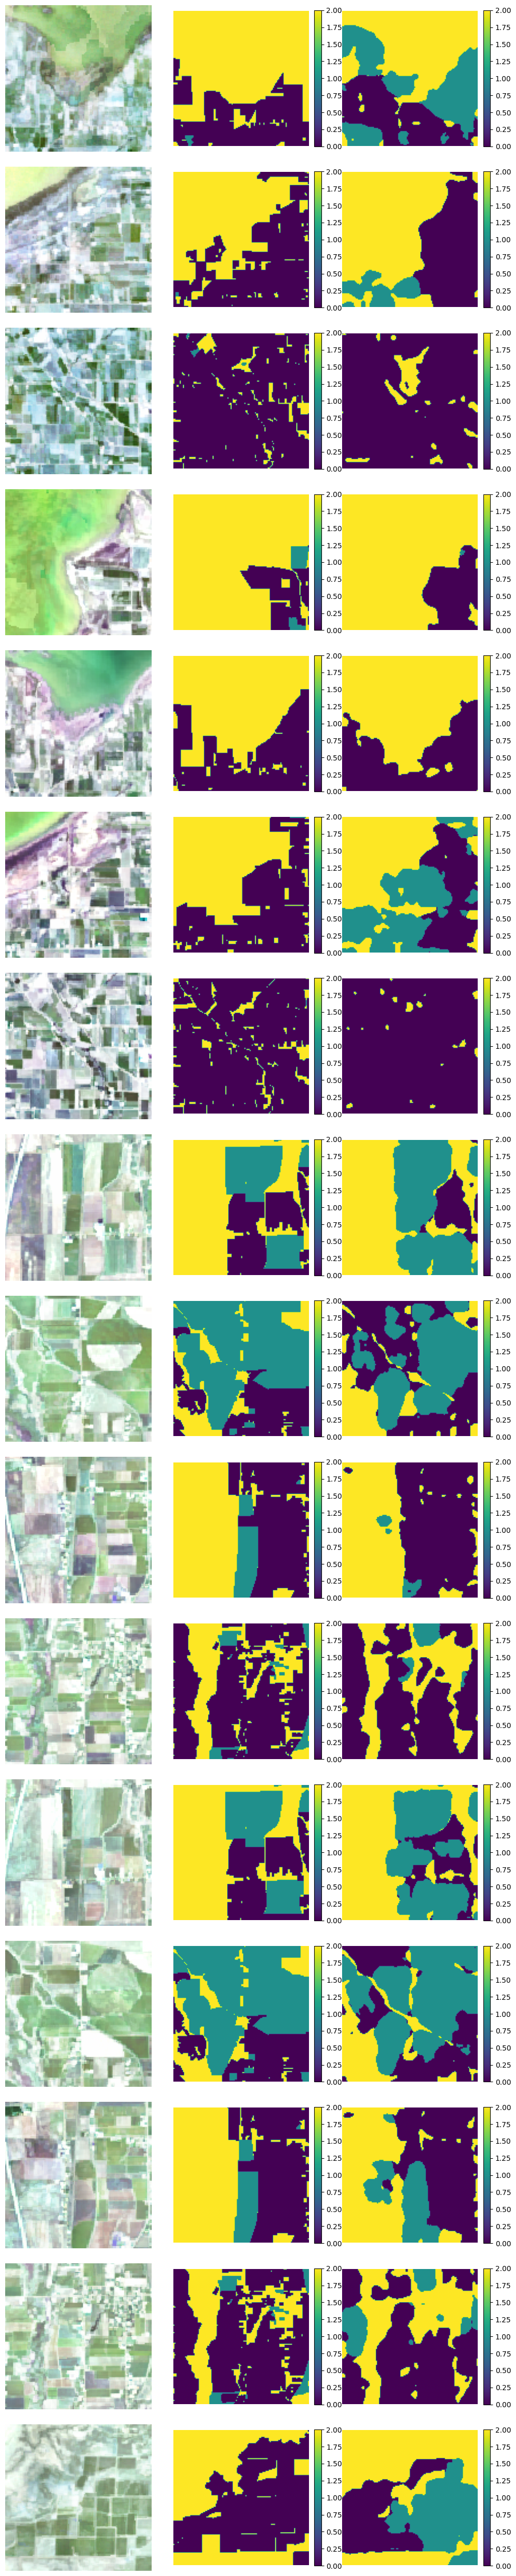

In [14]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf

# Assuming model, valid_img_gen are defined, and weights are loaded
x = valid_img_gen.take(5)
fig, axs = plt.subplots(16, 3, figsize=(10, 50))

for images, labels in x:
    preds = model.predict(images)
    for i in range(16):
        image = images[i].numpy()
        label = labels[i].numpy()  # Adjusted for direct numpy conversion
        masks = np.argmax(label, axis=-1)
        pred_mask = np.argmax(preds[i], axis=-1)

        # Display the image
        im0 = axs[i][0].imshow(image[:,:,:3])
        # Display the true mask
        im1 = axs[i][1].imshow(masks)
        # Display the predicted mask
        im2 = axs[i][2].imshow(pred_mask)

        # Remove ticks
        axs[i][0].axis('off')
        axs[i][1].axis('off')
        axs[i][2].axis('off')

        # Add colorbars
        # For the true mask
        fig.colorbar(im1, ax=axs[i][1], fraction=0.046, pad=0.04)
        # For the predicted mask
        fig.colorbar(im2, ax=axs[i][2], fraction=0.046, pad=0.04)

    break  # Since you have a break here, it only goes through the loop once

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


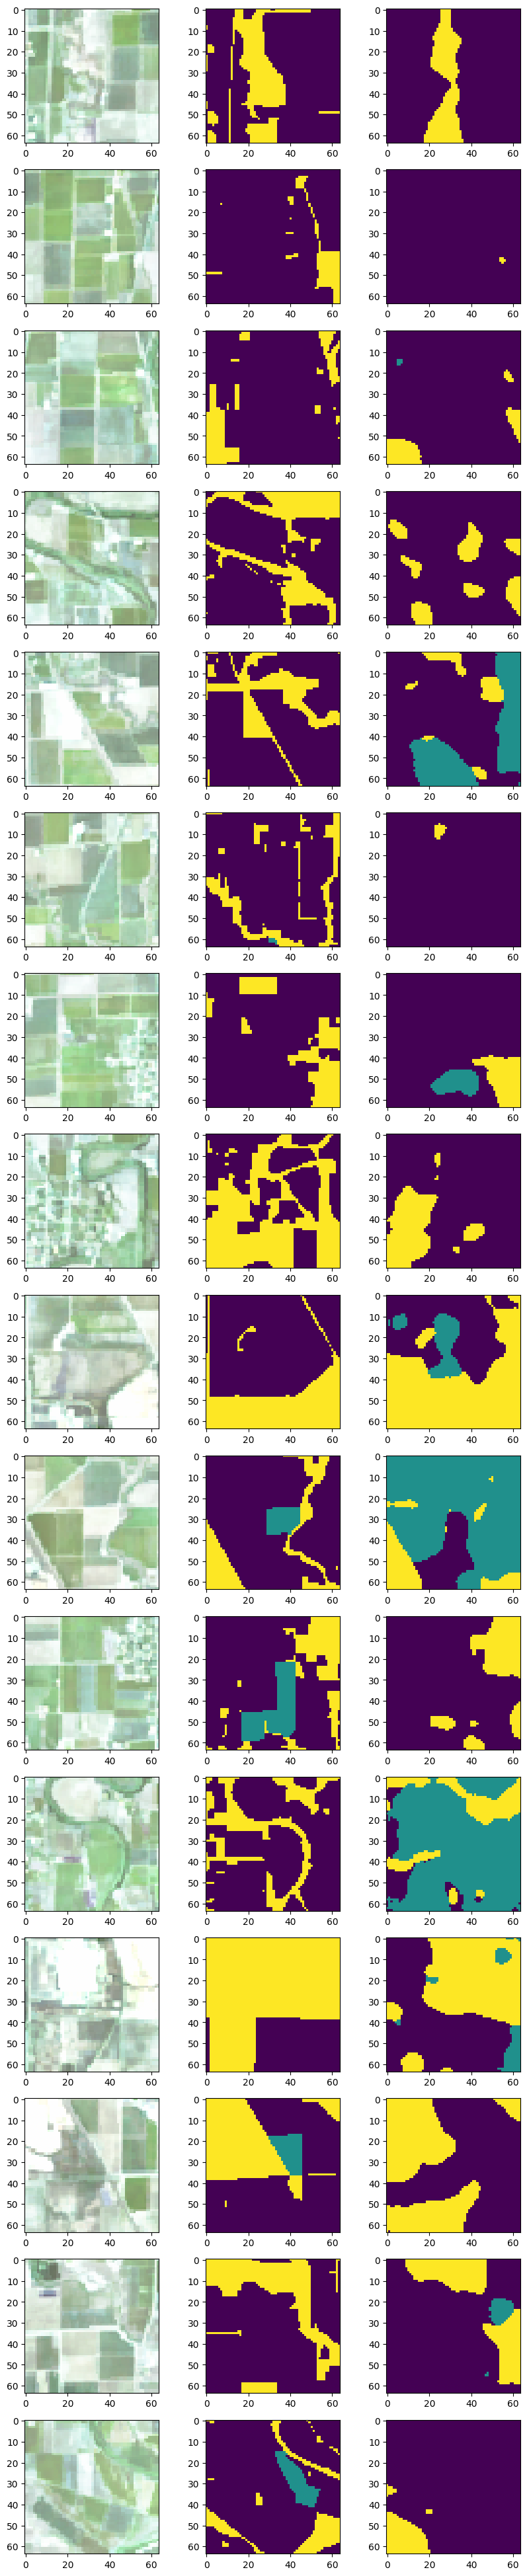

In [15]:
model.load_weights('model_ckpt/mres50_1.weights.h5')
x = valid_img_gen.take(1)
fig,axs = plt.subplots(16,3,figsize=(10, 50))
for images,labels in x:
    # print(images.shape)
    preds=model.predict(images)
    # print(np.array(preds).shape)
    for i in range(16):
        image = images[i].numpy()
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        print(labels[i].shape)
        masks = np.argmax(labels[i],axis=-1)
        pred_mask = np.argmax(preds[i],axis=-1)
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(pred_mask)
    break

### Extra

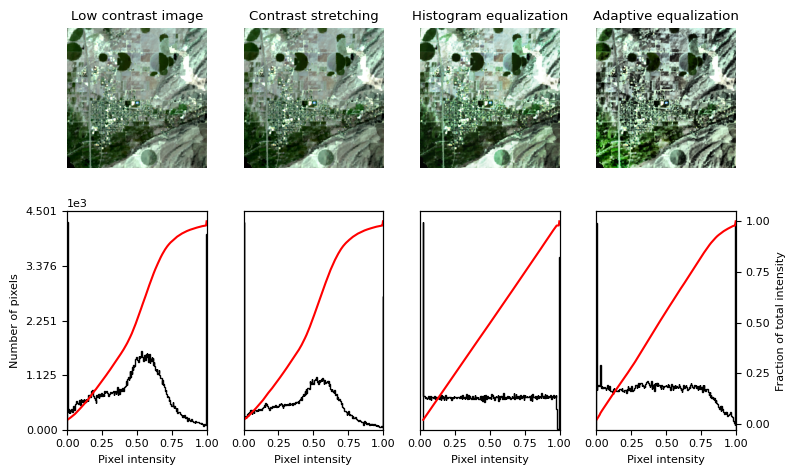

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


im = iter(training.take(2)).next()
img = im[0].numpy()[0][:,:,0:3]+np.array([0.5,0.6,0.5])
img = normalize_satellite_image(img)
# # Load an example image
# img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (3, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()